In [1]:
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql import functions as F
spark = SparkSession.builder.getOrCreate()

# 1.1)Dataset regroupant les régions,classe d'âge, reanimation,hostpitalisation, et guérison

In [2]:
path = "./data/donnees-hospitalieres-classe-age-covid19-2021-01-20-19h03.csv"
df = spark.read.format('csv').options(header=True, inferShema=True, delimiter=';').load(path)
df.printSchema()

df.show()

root
 |-- reg: string (nullable = true)
 |-- cl_age90: string (nullable = true)
 |-- jour: string (nullable = true)
 |-- hosp: string (nullable = true)
 |-- rea: string (nullable = true)
 |-- rad: string (nullable = true)
 |-- dc: string (nullable = true)

+---+--------+----------+----+---+---+---+
|reg|cl_age90|      jour|hosp|rea|rad| dc|
+---+--------+----------+----+---+---+---+
| 01|       0|2020-03-18|   0|  0|  0|  0|
| 01|      09|2020-03-18|   0|  0|  0|  0|
| 01|      19|2020-03-18|   0|  0|  0|  0|
| 01|      29|2020-03-18|   0|  0|  0|  0|
| 01|      39|2020-03-18|   0|  0|  0|  0|
| 01|      49|2020-03-18|   0|  0|  0|  0|
| 01|      59|2020-03-18|   0|  0|  0|  0|
| 01|      69|2020-03-18|   0|  0|  0|  0|
| 01|      79|2020-03-18|   0|  0|  0|  0|
| 01|      89|2020-03-18|   0|  0|  0|  0|
| 01|      90|2020-03-18|   0|  0|  0|  0|
| 02|       0|2020-03-18|  16|  5|  0|  1|
| 02|      09|2020-03-18|   0|  0|  0|  0|
| 02|      19|2020-03-18|   0|  0|  0|  0|
| 02|      2

# 1) Aperçu général

In [3]:
#Describe
df_reduce = df.drop("jour")
df_summary = df_reduce.describe()
df_summary.show()

+-------+------------------+-----------------+------------------+------------------+-----------------+-----------------+
|summary|               reg|         cl_age90|              hosp|               rea|              rad|               dc|
+-------+------------------+-----------------+------------------+------------------+-----------------+-----------------+
|  count|             61182|            61182|             61182|             61182|            61182|            61182|
|   mean|39.388888888888886|48.27272727272727|164.99123925337517|22.707806217514957|976.5033506586905|232.1244810565199|
| stddev| 32.28741109923755|30.26601231024996| 578.2811559515713| 90.83477149520677|3174.888206060533|801.5843552179239|
|    min|                01|                0|                 0|                 0|                0|                0|
|    max|                94|               90|               999|                99|              999|              999|
+-------+------------------+----

# 2)Moyenne de décès par régions

In [4]:

moy_dc_rg = df.groupBy('reg').agg({"dc":"mean"}).show()

+---+------------------+
|reg|           avg(dc)|
+---+------------------+
| 11|1425.2156516622535|
| 01|11.911738746690203|
| 28|112.41629891144454|
| 52|108.72109443954105|
| 27| 227.2647837599294|
| 75|118.64607237422771|
| 93|258.86231244483673|
| 03| 6.929096793174463|
| 02|3.9711679905854664|
| 44|  677.531332744925|
| 53| 60.54310091203295|
| 06|4.6163577522800825|
| 84| 475.4365989997058|
| 24|117.50426596057665|
| 32| 403.2953809944101|
| 04| 3.160341276846131|
| 94|12.505442777287438|
| 76|149.70962047661078|
+---+------------------+



# 3)Max de décès et de rétablissements par régions

In [5]:

max_rad_dc = df.groupBy('cl_age90').agg({"dc":"max","rad":"max"}).sort('cl_age90').show()

+--------+--------+-------+
|cl_age90|max(rad)|max(dc)|
+--------+--------+-------+
|       0|    9981|    999|
|      09|      99|      3|
|      19|      99|      4|
|      29|     997|      9|
|      39|     999|      9|
|      49|     998|     99|
|      59|     999|     99|
|      69|     999|    992|
|      79|     999|    997|
|      89|     999|    997|
|      90|     998|    998|
+--------+--------+-------+



# 4)Moyenne des admis en réanimation,hospitalisation et décès

In [6]:
df_moy_age = df_reduce.groupBy(['cl_age90']).agg({"rea":"mean","rad":"mean","hosp":"mean"}).sort("cl_age90")
df_moy_age.show()




+--------+------------------+------------------+-------------------+
|cl_age90|          avg(rad)|         avg(hosp)|           avg(rea)|
+--------+------------------+------------------+-------------------+
|       0| 5389.694174757282| 911.1129090255304| 125.39679971233369|
|      09| 56.50071916576771| 2.538115785688601|0.44156778137360664|
|      19| 47.55231930960086| 2.759439050701187|0.44156778137360664|
|      29|  192.351492268968| 9.253505933117584| 1.1049982020855806|
|      39| 322.3653362099964| 18.46997482919813|  3.118482560230133|
|      49| 477.8383674937073| 35.98759439050701| 7.8042071197411005|
|      59| 772.7603380079108| 81.56418554476807| 20.724020136641496|
|      69| 954.5688601222582|149.65336209996403| 39.277058612010066|
|      79|1018.6612729234089|213.59726717008272|  40.22761596548004|
|      89|1038.3532901833873|  260.123696512046| 10.257281553398059|
|      90|470.89068680330814| 129.8435814455232| 0.9922689679971234|
+--------+------------------+-----

In [7]:
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf

**Transformation de la date en date.date()

In [8]:
from pyspark.sql.types import TimestampType

@udf(returnType = TimestampType())
def transform_timestamp_in_date(timestamp):
    from datetime import datetime
    return datetime.strptime(timestamp, "%Y-%m-%d")

In [9]:
df_with_date = df.withColumn('datestamp',transform_timestamp_in_date("jour"))
df_with_date.show()

+---+--------+----------+----+---+---+---+-------------------+
|reg|cl_age90|      jour|hosp|rea|rad| dc|          datestamp|
+---+--------+----------+----+---+---+---+-------------------+
| 01|       0|2020-03-18|   0|  0|  0|  0|2020-03-18 00:00:00|
| 01|      09|2020-03-18|   0|  0|  0|  0|2020-03-18 00:00:00|
| 01|      19|2020-03-18|   0|  0|  0|  0|2020-03-18 00:00:00|
| 01|      29|2020-03-18|   0|  0|  0|  0|2020-03-18 00:00:00|
| 01|      39|2020-03-18|   0|  0|  0|  0|2020-03-18 00:00:00|
| 01|      49|2020-03-18|   0|  0|  0|  0|2020-03-18 00:00:00|
| 01|      59|2020-03-18|   0|  0|  0|  0|2020-03-18 00:00:00|
| 01|      69|2020-03-18|   0|  0|  0|  0|2020-03-18 00:00:00|
| 01|      79|2020-03-18|   0|  0|  0|  0|2020-03-18 00:00:00|
| 01|      89|2020-03-18|   0|  0|  0|  0|2020-03-18 00:00:00|
| 01|      90|2020-03-18|   0|  0|  0|  0|2020-03-18 00:00:00|
| 02|       0|2020-03-18|  16|  5|  0|  1|2020-03-18 00:00:00|
| 02|      09|2020-03-18|   0|  0|  0|  0|2020-03-18 00


# 5)Pandas

In [10]:
data = pd.read_csv("./data/donnees-hospitalieres-classe-age-covid19-2021-01-20-19h03.csv", sep=";")

data.head()

,reg,cl_age90,jour,hosp,rea,rad,dc
0,1,0,2020-03-18,0,0,0,0
1,1,9,2020-03-18,0,0,0,0
2,1,19,2020-03-18,0,0,0,0
3,1,29,2020-03-18,0,0,0,0
4,1,39,2020-03-18,0,0,0,0


# 5-1)Décès par classe d'âge

               dc
cl_age90         
0         7121268
9             876
19           1162
29           7443
39          29990
49          83167
59         299416
69         807349
79        1585528
89        2708743
90        1556898


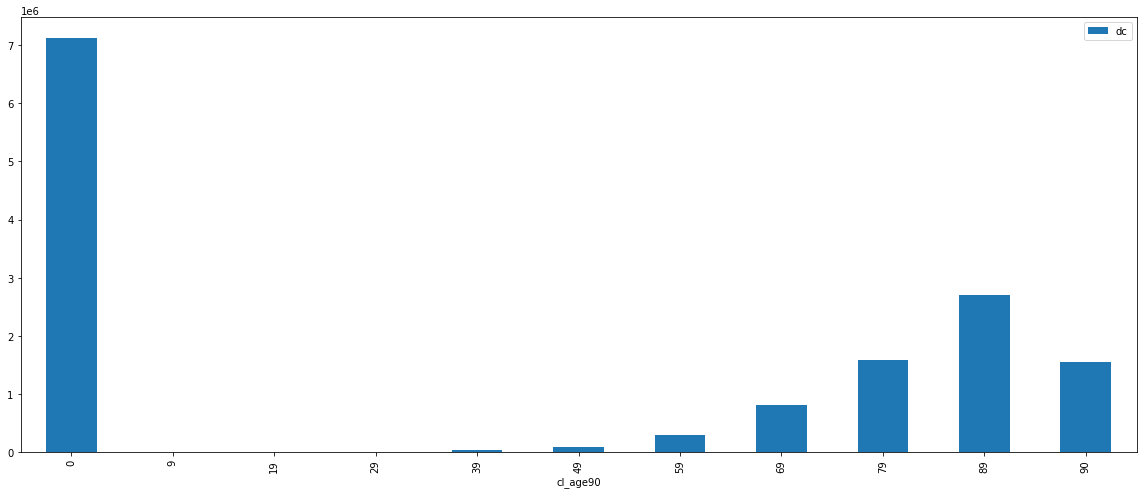

In [11]:
data_max_dc = data.groupby('cl_age90').agg({'dc':'sum'})
data_max_dc.plot.bar(title="", figsize=(20, 8))
print(data_max_dc)

# 5-2)La région la plus touchée

        dc
reg       
1      169
2       44
3       72
4       54
6       44
11   12897
24    1525
27    3077
28    1730
32    4978
44    6730
52    1565
53     830
75    2036
76    2399
84    7577
93    4133
94     120


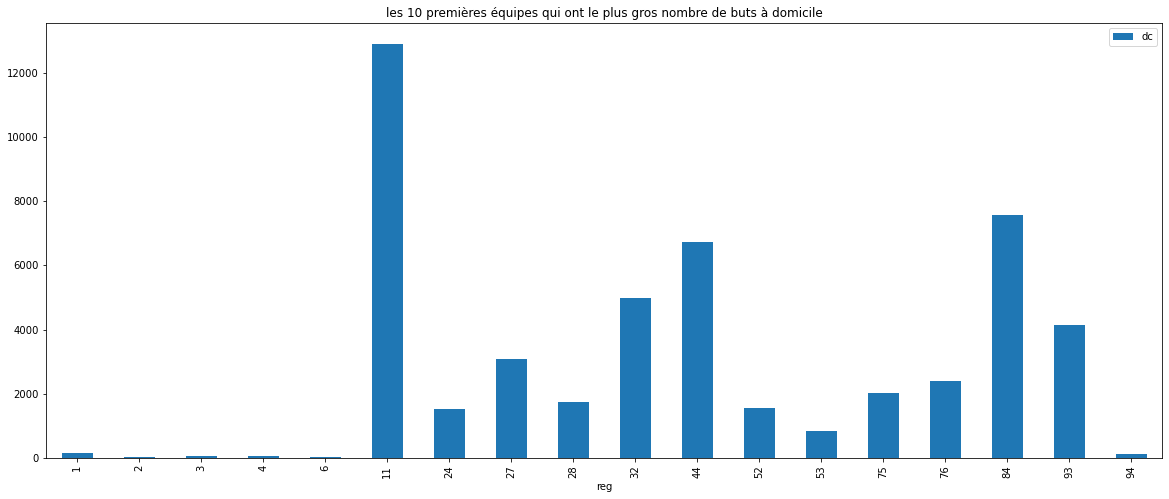

In [12]:
data_max_dc_reg = data.groupby('reg').agg({'dc':'max'})
data_max_dc_reg.plot.bar(title="les 10 premières équipes qui ont le plus gros nombre de buts à domicile", figsize=(20, 8))
print(data_max_dc_reg)

# 5-3)Moyenne des décès par classe d'âge avec pandas

In [13]:
#Moyenne des dc par tranche d'âge avec pandas
data_moy_age = data.drop('reg',axis=1).groupby(['cl_age90']).mean()
data_moy_age

,hosp,rea,rad,dc
cl_age90,,,,
0,911.112909,125.396800,5389.694175,1280.343042
9,2.538116,0.441568,56.500719,0.157497
19,2.759439,0.441568,47.552319,0.208918
29,9.253506,1.104998,192.351492,1.338188
39,18.469975,3.118483,322.365336,5.391945
49,35.987594,7.804207,477.838367,14.952715
59,81.564186,20.724020,772.760338,53.832434
69,149.653362,39.277059,954.568860,145.154441
79,213.597267,40.227616,1018.661273,285.064365


**Indexer suivant la colonne des jours:

In [14]:
#Mettre les jours en index pour mieux manipuler la suite des plot
data = df_with_date.toPandas()
data = data.set_index('datestamp')
data.dc = pd.to_numeric(data.dc, errors='coerce')
data.rad = pd.to_numeric(data.rad, errors='coerce')
data.hosp = pd.to_numeric(data.hosp, errors='coerce')
data.rea = pd.to_numeric(data.rea, errors='coerce')

# 5-4)Comparaison entre la moyenne et max de décès (semaine,mois)

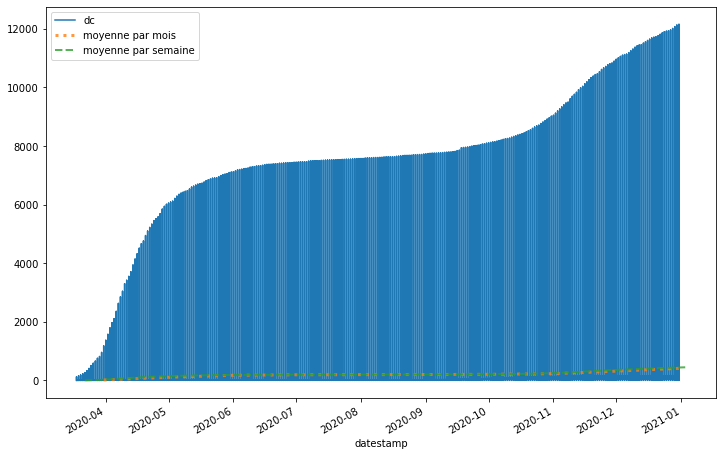

In [15]:
plt.figure(figsize=(12, 8))
data.loc['2020', 'dc'].plot()
data.loc['2020', 'dc'].resample('M').mean().plot(label='moyenne par mois', lw=3, ls=':', alpha=0.8)
data.loc['2020', 'dc'].resample('W').mean().plot(label='moyenne par semaine', lw=2, ls='--', alpha=0.8)
plt.legend()
plt.show()

# 5-4)Comparaison entre la moyenne et max des rétablissements (semaine,mois)

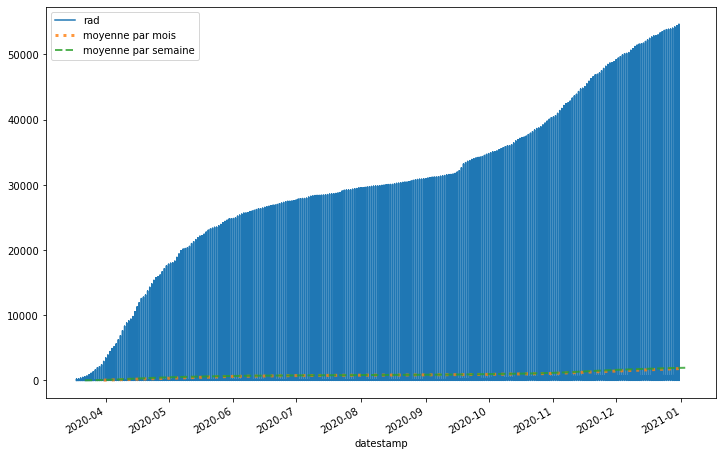

In [16]:
plt.figure(figsize=(12, 8))
data.loc['2020', 'rad'].plot()
data.loc['2020', 'rad'].resample('M').mean().plot(label='moyenne par mois', lw=3, ls=':', alpha=0.8)
data.loc['2020', 'rad'].resample('W').mean().plot(label='moyenne par semaine', lw=2, ls='--', alpha=0.8)
plt.legend()
plt.show()

# 5-5)Moyenne des décès et des guéris 

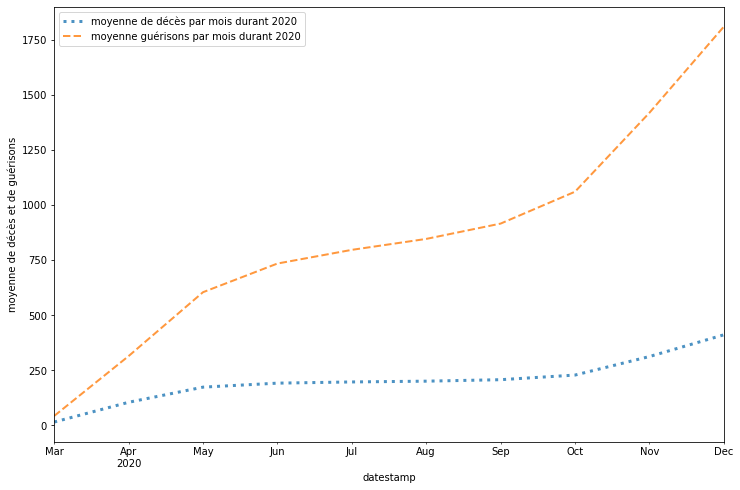

In [17]:
plt.figure(figsize=(12,8))
plt.ylabel("moyenne de décès et de guérisons")
data['2020']['dc'].resample('M').mean().plot(label="moyenne de décès par mois durant 2020", lw=3, ls=":", alpha=0.8)
data['2020']['rad'].resample('M').mean().plot(label="moyenne guérisons par mois durant 2020", lw=2, ls="--", alpha=0.8)
plt.legend()
plt.show()

# 5-6)Moyenne des admis en réanimation et des guéris

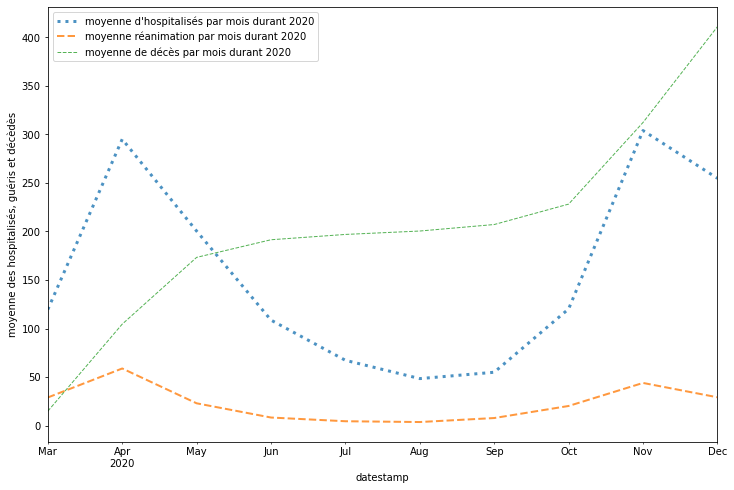

In [18]:
plt.figure(figsize=(12,8))
plt.ylabel("moyenne des hospitalisés, guéris et décèdès")
data['2020']['hosp'].resample('M').mean().plot(label="moyenne d'hospitalisés par mois durant 2020", lw=3, ls=":", alpha=0.8)
data['2020']['rea'].resample('M').mean().plot(label="moyenne réanimation par mois durant 2020", lw=2, ls="--", alpha=0.8)
data['2020']['dc'].resample('M').mean().plot(label="moyenne de décès par mois durant 2020", lw=1, ls="dashed", alpha=0.8)
plt.legend()
plt.show()


# 5-7) Mean,Std,Max,Min :

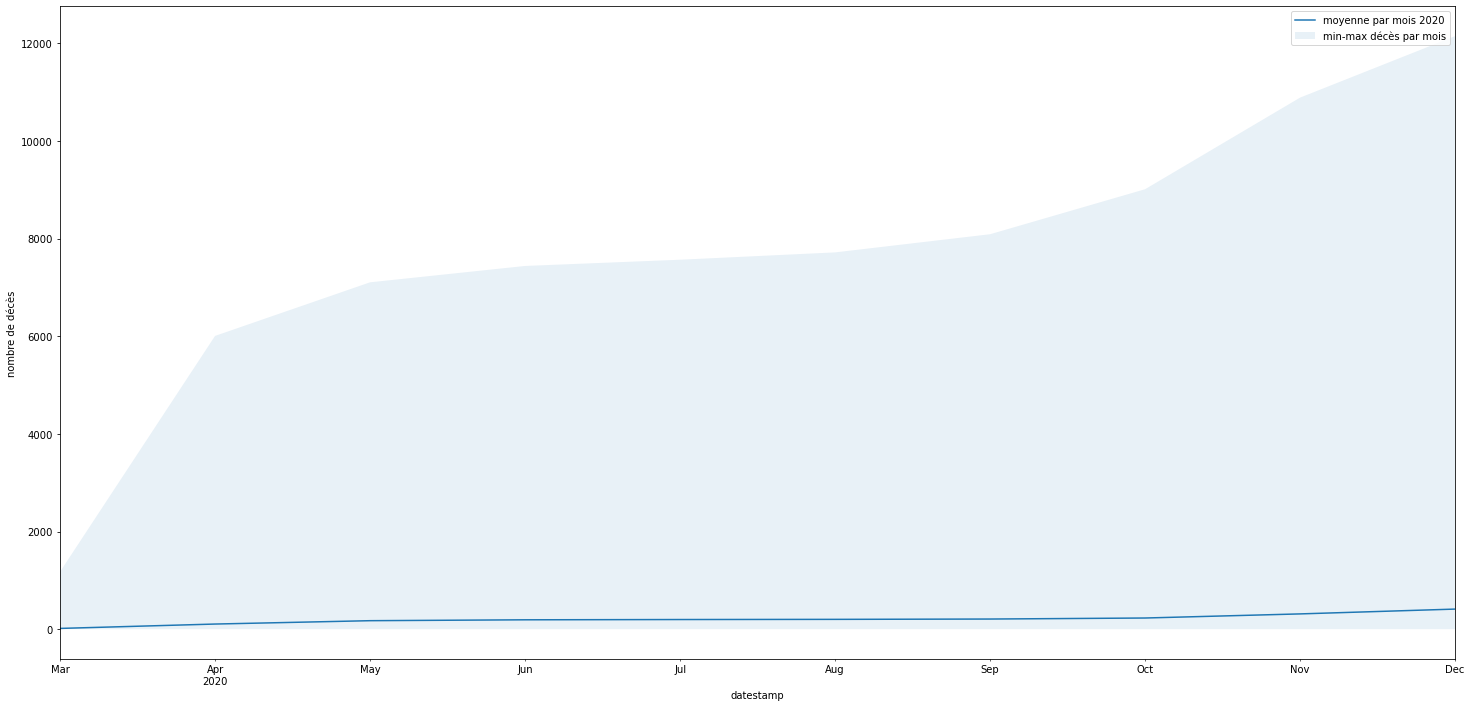

In [19]:
deces = data['2020']['dc'].resample('M').agg(['mean','std','max','min'])

# Le graphe
plt.figure(figsize=(25,12))
plt.ylabel("nombre de décès")
deces['mean'].plot(label="moyenne par mois 2020")
plt.fill_between(deces.index, deces['max'], deces['min'], alpha=0.1, label="min-max décès par mois")
plt.legend()
plt.show()

# 5-8) Mean,Std,Max,Min :

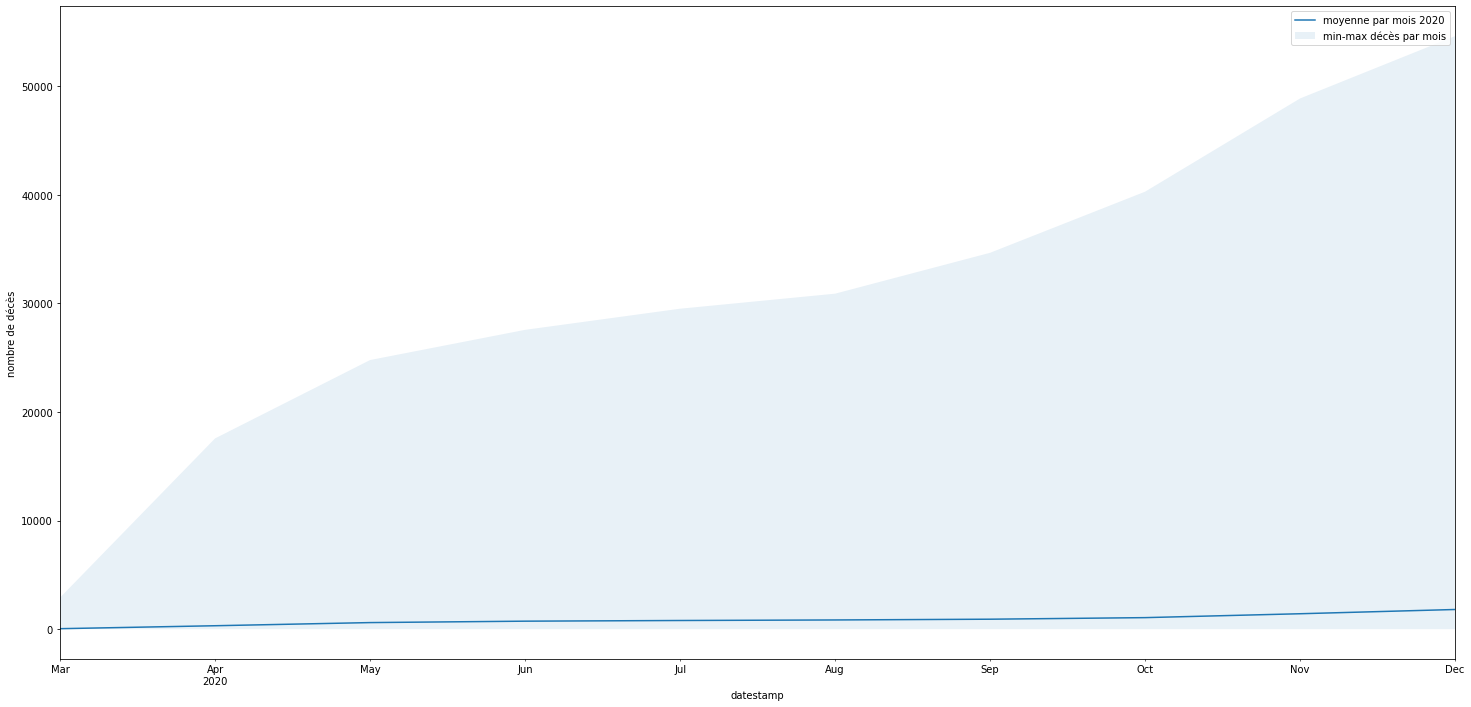

In [20]:
deces = data['2020']['rad'].resample('M').agg(['mean','std','max','min'])

# Le graphe
plt.figure(figsize=(25,12))
plt.ylabel("nombre de décès")
deces['mean'].plot(label="moyenne par mois 2020")
plt.fill_between(deces.index, deces['max'], deces['min'], alpha=0.1, label="min-max décès par mois")
plt.legend()
plt.show()

# Le DataSet n°2

In [21]:
dataSet = pd.read_csv('./data/donnees-hospitalieres-covid19-2021-01-20-19h03.csv', sep=";")
dataSet.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


In [22]:
dataSet.drop(dataSet.loc[dataSet['sexe']== 0].index, inplace=True)

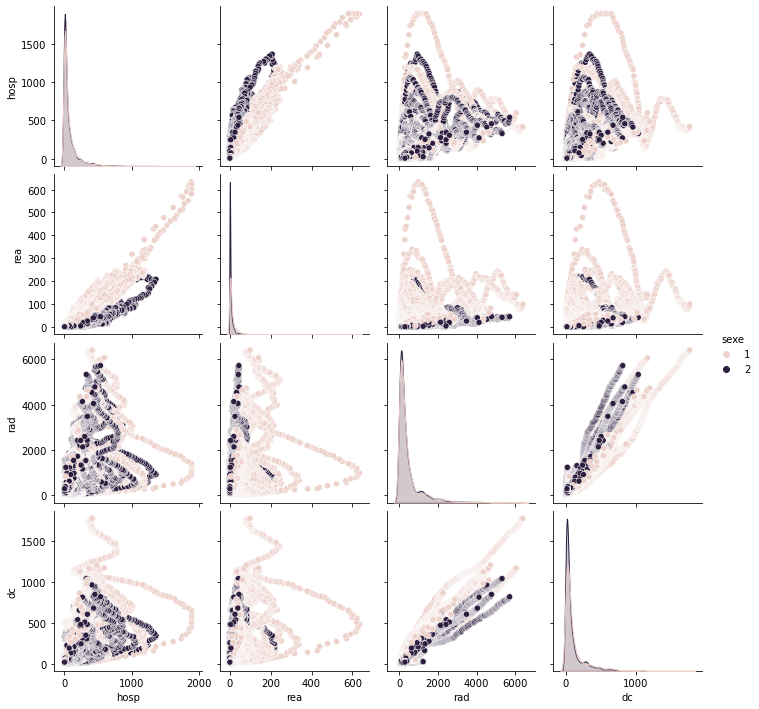

In [23]:
sns.pairplot(dataSet, hue="sexe" )